In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import datetime

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [8]:
all_sales = pd.read_csv('all_sales.csv')
all_sales

,date,sum_unit_sales
0,2013-01-01,2511.619
1,2013-01-02,496092.418
2,2013-01-03,361429.231
3,2013-01-04,354459.677
4,2013-01-05,477350.121
...,...,...
1679,2017-08-11,826373.722
1680,2017-08-12,792630.535
1681,2017-08-13,865639.677
1682,2017-08-14,760922.406


In [9]:
# Create new time features.
def create_features(df):
    
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    return df

all_sales['date'] = pd.to_datetime(all_sales['date'])
all_sales_date = create_features(all_sales)

C:\Users\ialsh\anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [10]:
all_sales_date = all_sales_date.set_index(pd.DatetimeIndex(all_sales_date['date'])) 
all_sales_date.drop(['date'], axis = 1, inplace = True)

In [11]:
all_sales_date

,sum_unit_sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,
2013-01-01,2511.619,1,1,1,2013,1,1,1
2013-01-02,496092.418,2,1,1,2013,2,2,1
2013-01-03,361429.231,3,1,1,2013,3,3,1
2013-01-04,354459.677,4,1,1,2013,4,4,1
2013-01-05,477350.121,5,1,1,2013,5,5,1
...,...,...,...,...,...,...,...,...
2017-08-11,826373.722,4,3,8,2017,223,11,32
2017-08-12,792630.535,5,3,8,2017,224,12,32
2017-08-13,865639.677,6,3,8,2017,225,13,32


In [12]:
# Split data

split_date = '2016-08-16'
train = all_sales_date[all_sales_date.index < split_date]
test = all_sales_date[all_sales_date.index >= split_date]

In [13]:
train.shape, test.shape

((1320, 8), (364, 8))

In [14]:
X_train, y_train = train.drop(['sum_unit_sales'], axis=1), train['sum_unit_sales']
X_test, y_test = test.drop(['sum_unit_sales'], axis=1), test['sum_unit_sales']

#### XGBoost

In [15]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

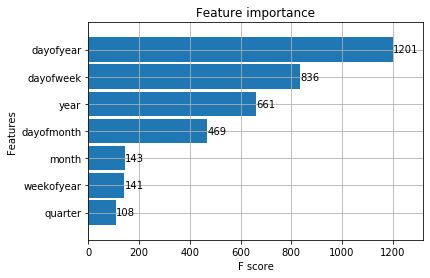

In [16]:
# Feature importance
_ = plot_importance(reg, height=0.9)

The day of the year was most often used to divide trees, followed by the day of the week and the year itself. 

In [17]:
test['XGBoost_pred'] = reg.predict(X_test)

C:\Users\ialsh\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
test

,sum_unit_sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,XGBoost_pred
date,,,,,,,,,
2016-08-16,718671.651,1,3,8,2016,229,16,33,678917.8750
2016-08-17,725945.703,2,3,8,2016,230,17,33,688247.1250
2016-08-18,577350.521,3,3,8,2016,231,18,33,572598.8750
2016-08-19,678767.116,4,3,8,2016,232,19,33,666363.3750
2016-08-20,828986.336,5,3,8,2016,233,20,33,780384.3125
...,...,...,...,...,...,...,...,...,...
2017-08-11,826373.722,4,3,8,2017,223,11,32,659333.2500
2017-08-12,792630.535,5,3,8,2017,224,12,32,754675.8125
2017-08-13,865639.677,6,3,8,2017,225,13,32,777928.8750


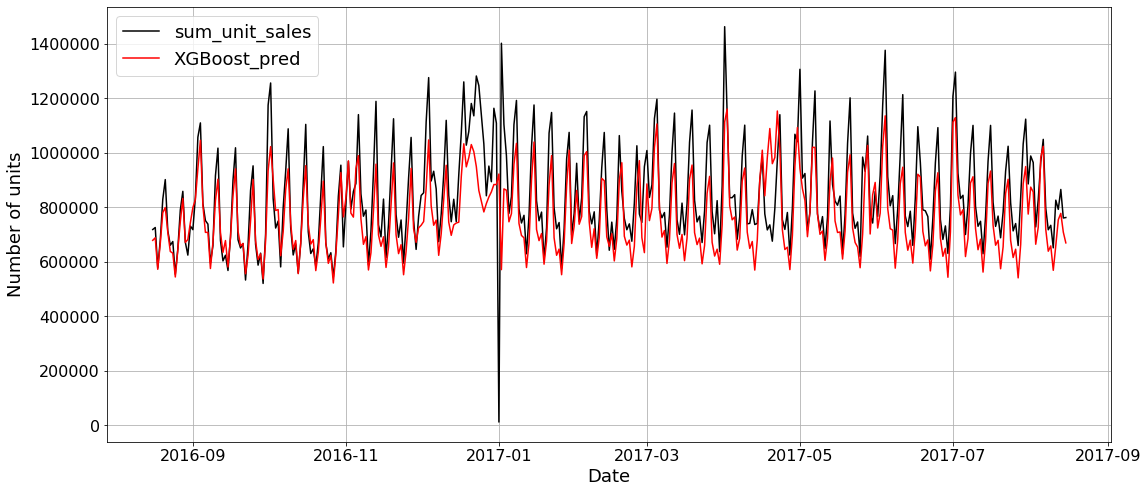

In [19]:
f, ax = plt.subplots(1, 1, figsize=(18, 8))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.plot(test.index, test['sum_unit_sales'], 'k') 
ax.plot(test.index, test['XGBoost_pred'], 'r') 
ax.legend(['sum_unit_sales', 'XGBoost_pred'],
          fontsize=18)
#ax.plot(data.index, data['lower_line'], 'r')
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Number of units', fontsize=18)
ax.grid()

In [20]:
print(f'RMSE: ', mean_squared_error(y_true=test['sum_unit_sales'], y_pred=test['XGBoost_pred']))
print(f'MAE: ', mean_absolute_error(y_true=test['sum_unit_sales'], y_pred=test['XGBoost_pred']))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'MAPE: ', mean_absolute_percentage_error(y_true=test['sum_unit_sales'], y_pred=test['XGBoost_pred']))

RMSE:  16989963600.391527
MAE:  95110.60873008241
MAPE:  31.00166147236674


#### CatBoost

In [21]:
cbr = CatBoostRegressor(n_estimators=1000)
cbr.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False)

In [22]:
test['CatBoost_pred'] = cbr.predict(X_test)

C:\Users\ialsh\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



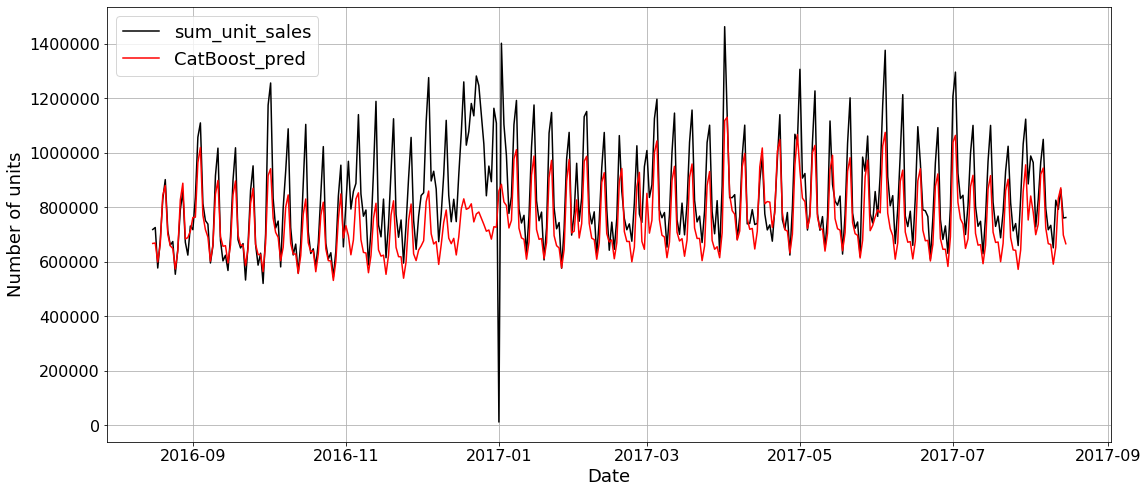

In [23]:
f, ax = plt.subplots(1, 1, figsize=(18, 8))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.plot(test.index, test['sum_unit_sales'], 'k') 
ax.plot(test.index, test['CatBoost_pred'], 'r') 
ax.legend(['sum_unit_sales', 'CatBoost_pred'],
          fontsize=18)
#ax.plot(data.index, data['lower_line'], 'r')
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Number of units', fontsize=18)
ax.grid()

In [24]:
print(f'RMSE: ', mean_squared_error(y_true=test['sum_unit_sales'], y_pred=test['CatBoost_pred']))
print(f'MAE: ', mean_absolute_error(y_true=test['sum_unit_sales'], y_pred=test['CatBoost_pred']))
print(f'MAPE: ', mean_absolute_percentage_error(y_true=test['sum_unit_sales'], y_pred=test['CatBoost_pred']))

RMSE:  21314798660.597313
MAE:  107033.44405499354
MAPE:  30.633410661370696


Both XGBoost and CatBoost in general were able to pick up on the trend. The plots clearly show that in both cases an increase or decrease in the number of sales is correctly predicted, with a very similar error in size. However, in both cases, the predicted values turned out to be underestimated relative to the true ones. Moreover, XGBoost did a better job at predicting the behavior of the graph in the area of the new year, and will be used in the following steps.

In [25]:
# Add holidays data
holiday = pd.read_csv('holidays_events.csv')
holiday

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [26]:
holidays = []
for date in train.index:
    if str(date)[:10] in holiday['date'].values:
        holidays.append(1)
    else:
        holidays.append(0)
    
train['holiday'] = holidays

C:\Users\ialsh\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
holidays = []
for date in test.index:
    if str(date)[:10] in holiday['date'].values:
        holidays.append(1)
    else:
        holidays.append(0)
    
test['holiday'] = holidays

C:\Users\ialsh\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
train['holiday'].value_counts()

0    1117
1     203
Name: holiday, dtype: int64

In [29]:
test['holiday'].value_counts()

0    315
1     49
Name: holiday, dtype: int64

In [30]:
X_train, y_train = train.drop(['sum_unit_sales'], axis=1), train['sum_unit_sales']
X_test, y_test = test.drop(['sum_unit_sales', 'XGBoost_pred', 'CatBoost_pred'], axis=1), test['sum_unit_sales']

In [31]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

test['XGBoost_pred_holidays'] = reg.predict(X_test) + 100000 # correction, as predictions are underestimated

print(f'RMSE: ', mean_squared_error(y_true=test['sum_unit_sales'], y_pred=test['XGBoost_pred_holidays']))
print(f'MAE: ', mean_absolute_error(y_true=test['sum_unit_sales'], y_pred=test['XGBoost_pred_holidays']))
print(f'MAPE: ', mean_absolute_percentage_error(y_true=test['sum_unit_sales'], y_pred=test['XGBoost_pred_holidays']))

RMSE:  11718224082.45867
MAE:  68762.21742857143
MAPE:  31.555164936528307


C:\Users\ialsh\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



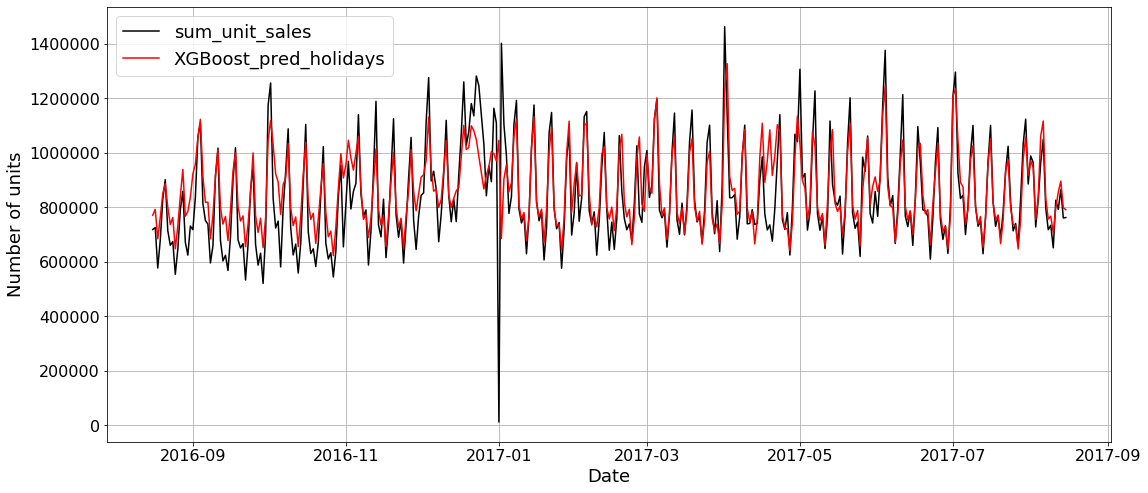

In [32]:
f, ax = plt.subplots(1, 1, figsize=(18, 8))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.plot(test.index, test['sum_unit_sales'], 'k') 
ax.plot(test.index, test['XGBoost_pred_holidays'], 'r') 
ax.legend(['sum_unit_sales', 'XGBoost_pred_holidays'],
          fontsize=18)
#ax.plot(data.index, data['lower_line'], 'r')
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Number of units', fontsize=18)
ax.grid()

Adding holidays data did not improve predictive algorithm

In [33]:
# Add lags
test.shape

(364, 12)

In [34]:
all_data = pd.concat([train, test])

In [35]:
all_data = all_data.drop(['XGBoost_pred', 'CatBoost_pred', 'XGBoost_pred_holidays', 'holiday'], axis=1)

In [36]:
for i in range(1, 366):
    all_data[f'shift{i}'] = all_data['sum_unit_sales'].shift(i)

C:\Users\ialsh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [37]:
split_date = '2016-08-16'
train = all_data[all_data.index < split_date]
test = all_data[all_data.index >= split_date]

In [38]:
train

,sum_unit_sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,shift1,shift2,...,shift356,shift357,shift358,shift359,shift360,shift361,shift362,shift363,shift364,shift365
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,2511.619,1,1,1,2013,1,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,496092.418,2,1,1,2013,2,2,1,2511.619,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,361429.231,3,1,1,2013,3,3,1,496092.418,2511.619,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,354459.677,4,1,1,2013,4,4,1,361429.231,496092.418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,477350.121,5,1,1,2013,5,5,1,354459.677,361429.231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-11,596729.280,3,3,8,2016,224,11,32,658457.436,635538.981,...,569443.704,653733.360,629475.643,694747.162,913846.625,936339.026,734484.205,557859.478,678064.732,668280.358
2016-08-12,745662.505,4,3,8,2016,225,12,32,596729.280,658457.436,...,653281.208,569443.704,653733.360,629475.643,694747.162,913846.625,936339.026,734484.205,557859.478,678064.732
2016-08-13,714905.919,5,3,8,2016,226,13,32,745662.505,596729.280,...,803270.158,653281.208,569443.704,653733.360,629475.643,694747.162,913846.625,936339.026,734484.205,557859.478


In [39]:
test

,sum_unit_sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,shift1,shift2,...,shift356,shift357,shift358,shift359,shift360,shift361,shift362,shift363,shift364,shift365
date,,,,,,,,,,,,,,,,,,,,,
2016-08-16,718671.651,1,3,8,2016,229,16,33,720032.300,761826.128,...,624698.338,681575.990,865755.397,803270.158,653281.208,569443.704,653733.360,629475.643,694747.162,913846.625
2016-08-17,725945.703,2,3,8,2016,230,17,33,718671.651,720032.300,...,640075.991,624698.338,681575.990,865755.397,803270.158,653281.208,569443.704,653733.360,629475.643,694747.162
2016-08-18,577350.521,3,3,8,2016,231,18,33,725945.703,718671.651,...,548043.327,640075.991,624698.338,681575.990,865755.397,803270.158,653281.208,569443.704,653733.360,629475.643
2016-08-19,678767.116,4,3,8,2016,232,19,33,577350.521,725945.703,...,635737.232,548043.327,640075.991,624698.338,681575.990,865755.397,803270.158,653281.208,569443.704,653733.360
2016-08-20,828986.336,5,3,8,2016,233,20,33,678767.116,577350.521,...,876953.097,635737.232,548043.327,640075.991,624698.338,681575.990,865755.397,803270.158,653281.208,569443.704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,826373.722,4,3,8,2017,223,11,32,651386.912,734139.674,...,678767.116,577350.521,725945.703,718671.651,720032.300,761826.128,714905.919,745662.505,596729.280,658457.436
2017-08-12,792630.535,5,3,8,2017,224,12,32,826373.722,651386.912,...,828986.336,678767.116,577350.521,725945.703,718671.651,720032.300,761826.128,714905.919,745662.505,596729.280
2017-08-13,865639.677,6,3,8,2017,225,13,32,792630.535,826373.722,...,901870.150,828986.336,678767.116,577350.521,725945.703,718671.651,720032.300,761826.128,714905.919,745662.505


In [40]:
X_train, y_train = train.drop(['sum_unit_sales'], axis=1), train['sum_unit_sales']
X_test, y_test = test.drop(['sum_unit_sales'], axis=1), test['sum_unit_sales']

In [41]:
X_train.shape


(1320, 372)

In [42]:
y_train.shape

(1320,)

In [43]:
X_test.shape

(364, 372)

In [44]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False)

test['XGBoost_pred_holidays_lags'] = reg.predict(X_test)

C:\Users\ialsh\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
print(f'RMSE: ', mean_squared_error(y_true=test['sum_unit_sales'], y_pred=test['XGBoost_pred_holidays_lags']))
print(f'MAE: ', mean_absolute_error(y_true=test['sum_unit_sales'], y_pred=test['XGBoost_pred_holidays_lags']))
print(f'MAPE: ', mean_absolute_percentage_error(y_true=test['sum_unit_sales'], y_pred=test['XGBoost_pred_holidays_lags']))

RMSE:  13244672261.66548
MAE:  78075.79243681318
MAPE:  18.844145861235294


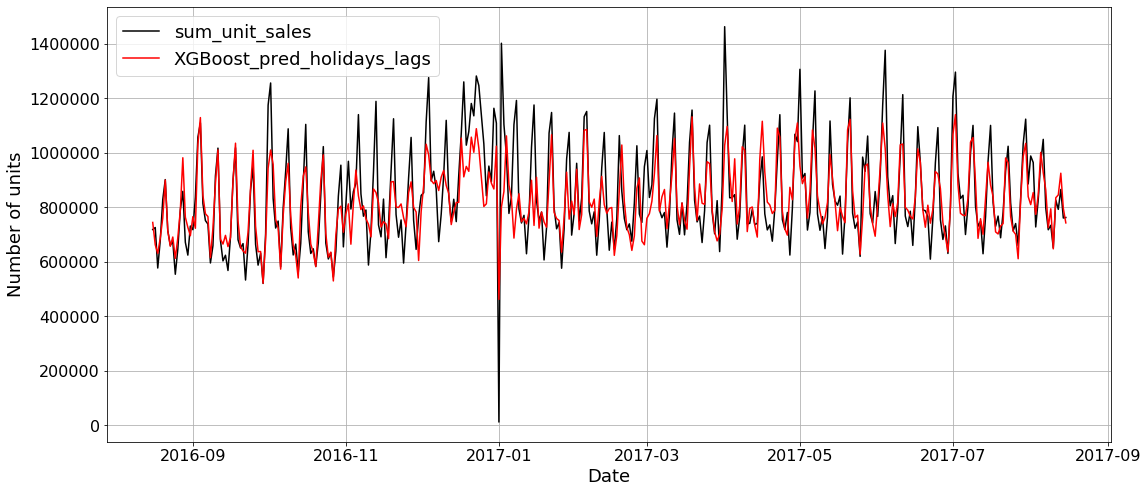

In [46]:
f, ax = plt.subplots(1, 1, figsize=(18, 8))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.plot(test.index, test['sum_unit_sales'], 'k') 
ax.plot(test.index, test['XGBoost_pred_holidays_lags'], 'r') 
ax.legend(['sum_unit_sales', 'XGBoost_pred_holidays_lags'],
          fontsize=18)
#ax.plot(data.index, data['lower_line'], 'r')
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Number of units', fontsize=18)
ax.grid()

After adding lags, the error was reduced to 19%. The graph shows that the model makes the largest error around the new year.

In [47]:
all_data[all_data['sum_unit_sales'] < 200000]

,sum_unit_sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,shift1,shift2,...,shift356,shift357,shift358,shift359,shift360,shift361,shift362,shift363,shift364,shift365
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,2511.6190,1,1,1,2013,1,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01,8602.0654,2,1,1,2014,1,1,1,507264.663,635134.736,...,3.025308e+05,318347.7780,336122.8010,519695.401,477350.121,354459.677,361429.2310,4.960924e+05,2.511619e+03,NaN
2015-01-01,12773.6170,3,1,1,2015,1,1,1,844380.470,912970.533,...,4.963779e+05,636176.8522,563450.5984,602268.564,949618.790,936628.887,680672.8456,8.010112e+05,8.602065e+03,507264.663
2016-01-01,16433.3940,4,1,1,2016,1,1,53,964641.541,1030043.736,...,4.393812e+05,417482.6890,494160.8500,477886.741,569267.298,730923.776,648880.6870,6.577634e+05,1.277362e+04,844380.470
2017-01-01,12082.5010,6,1,1,2017,1,1,52,1109012.812,1163643.038,...,1.094694e+06,989208.4580,713608.3340,653504.367,821685.656,835305.439,955956.8750,1.226736e+06,1.066677e+06,16433.394


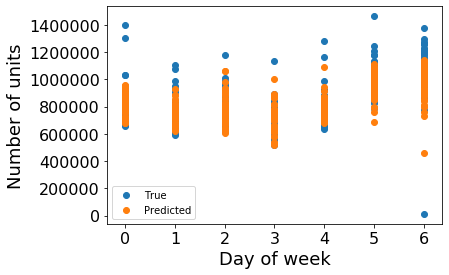

In [48]:
# The graphs also show that the model predicts underestimated values for weekends.
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Day of week', fontsize=18)
plt.ylabel('Number of units', fontsize=18)
plt.scatter(test['dayofweek'], test['sum_unit_sales']) 
plt.scatter(test['dayofweek'], test['XGBoost_pred_holidays_lags']) 
plt.legend(['True', 'Predicted'])

In [49]:
# New feature - difference between average number of sales during weekdays and weekends. 

av_weekday = train.groupby(['dayofweek'])['sum_unit_sales'].max().reset_index()
av_weekday['sum_unit_sales_norm'] = (av_weekday['sum_unit_sales']-av_weekday['sum_unit_sales'].min()
                                    )/(av_weekday['sum_unit_sales'].max()-av_weekday['sum_unit_sales'].min())
av_weekday

,dayofweek,sum_unit_sales,sum_unit_sales_norm
0,0,1345920.605,1.000000
1,1,1152089.208,0.571502
2,2,1196146.058,0.668897
3,3,1083680.315,0.420272
4,4,893569.902,0.000000
5,5,1179376.177,0.631825
6,6,1271833.739,0.836218


In [50]:
def day_of_week_average(row):
    return av_weekday[av_weekday['dayofweek']==row['dayofweek']]['sum_unit_sales_norm'].values[0]
                      
all_data['dayofweek_average'] = all_data.apply(day_of_week_average, axis=1)

In [51]:
split_date = '2016-08-16'
train = all_data[all_data.index < split_date]
test = all_data[all_data.index >= split_date]
X_train, y_train = train.drop(['sum_unit_sales'], axis=1), train['sum_unit_sales']
X_test, y_test = test.drop(['sum_unit_sales'], axis=1), test['sum_unit_sales']

In [52]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False)

test['XGBoost_pred_lags_dayofweek'] = reg.predict(X_test)

print(f'RMSE: ', mean_squared_error(y_true=test['sum_unit_sales'], y_pred=test['XGBoost_pred_lags_dayofweek']))
print(f'MAE: ', mean_absolute_error(y_true=test['sum_unit_sales'], y_pred=test['XGBoost_pred_lags_dayofweek']))
print(f'MAPE: ', mean_absolute_percentage_error(y_true=test['sum_unit_sales'], y_pred=test['XGBoost_pred_lags_dayofweek']))

RMSE:  13277646709.760452
MAE:  78660.90617513737
MAPE:  18.440758235448563


C:\Users\ialsh\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



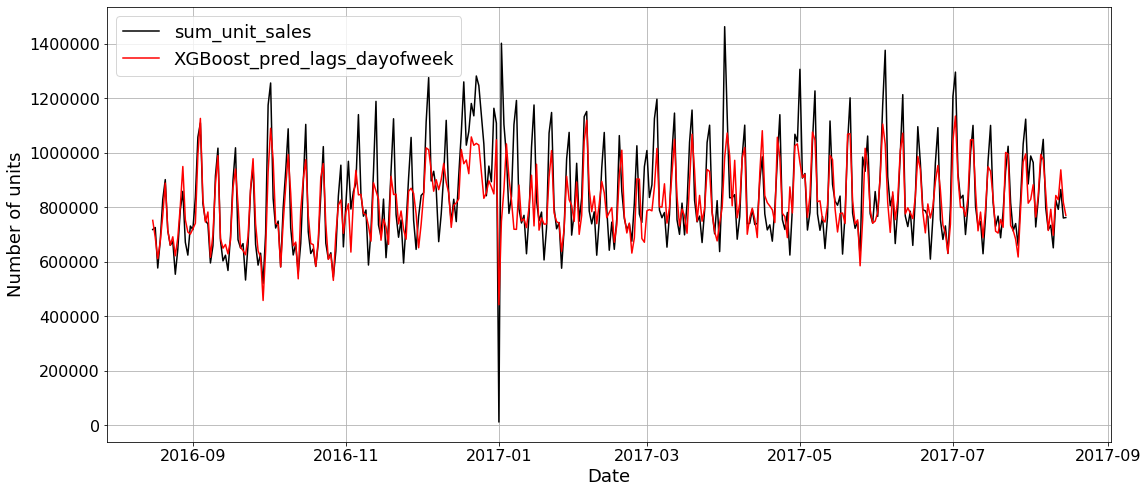

In [53]:
f, ax = plt.subplots(1, 1, figsize=(18, 8))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.plot(test.index, test['sum_unit_sales'], 'k') 
ax.plot(test.index, test['XGBoost_pred_lags_dayofweek'], 'r') 
ax.legend(['sum_unit_sales', 'XGBoost_pred_lags_dayofweek'],
          fontsize=18)
#ax.plot(data.index, data['lower_line'], 'r')
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Number of units', fontsize=18)
ax.grid()

#### Conlusion
Introducing lags has the most significant impact on model accuracy.

#### The best result   
XGBoost   
RMSE:  13277646709.8   
MAE:  78660.9   
MAPE:  18.4%   